# 2.1 Getting your data + feature engineering

## 2.1.1 Access to the data

In [10]:
# Libraries that we need
import pandas as pd
import numpy as np
#import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # to normalize the data
from sklearn.decomposition import PCA                                                                                                        

Let's import and see what the dataframe we need to work on looks like. 
There are 671736 rows × 8 columns, with *data.info()* we can figure out what they are and what types of data they contain.
We realize that both the _"datetime"_ column and the _"release_date"_ column should be of type datetime, so we proceed to convert them.

In [2]:
data = pd.read_csv("vodclickstream_uk_movies_03.csv")
data.datetime = pd.to_datetime(data.datetime)
data.release_date = pd.to_datetime(data.release_date, errors='coerce')

In [3]:
data.isna().sum() # only release_data has 30304 na values and they were the "NOT AVAILABLE", also genres has 26561 "NOT AVAILABLE" rows but we are not going to remove them because we do not want to loose data

Unnamed: 0          0
datetime            0
duration            0
title               0
genres              0
release_date    30304
movie_id            0
user_id             0
dtype: int64

In [4]:
to_drop = data[data["duration"] < 0].index # 21734 
# We can see that there are 21734 where duration is -1, we can drop them or convert this to 0 but 0 here has a different meaning so it's better to drop them
data = data.drop(to_drop).reset_index()

<Axes: title={'center': 'Duration distribution'}, ylabel='Frequency'>

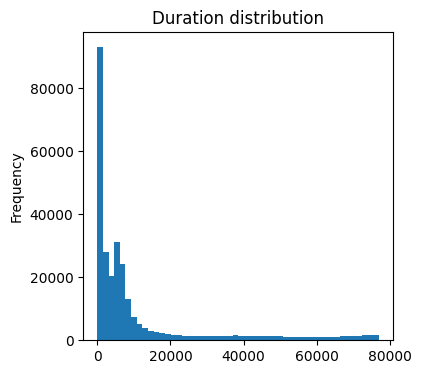

In [5]:
# Our only numeric variable is duration, let"s see how it is distributed
data.duration.describe() # We can see that the duration assumes values from 0 to 1.823725e+07 but the median is 43 and the 3rd quartile is 7059
# the duration is very often 0, but we can do an histogram exluding 0 and to big numbers to see how the other values are
data[(data["duration"] <= np.quantile(data["duration"],0.9)) & (data["duration"] > 0)].duration.plot(kind="hist",bins=50, figsize=(4,4), title = "Duration distribution") # we have lot of small numbers

## 2.1.2 feature engeneering of the 5 mandatory variables

### 1st feature, favorite genre
Here we have to create a new column for the genre the user spends most time.

In [6]:
# how many different genres we have? Let's count them
data.genres.apply(lambda row: row.split(","))
data["genres_list"] = ""
data["genres_list"] = data.genres.apply(lambda row: [word.strip() for word in row.split(",")])
data["genres_list"]
unique_genres = set()
data["genres_list"].apply(lambda row: [unique_genres.add(value) for value in row])
unique_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'NOT AVAILABLE',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [7]:
# Now we can create our new first feature
# First we need to divide the column with the list of the genres in rows cointaining only one genre
df_genres = data["genres_list"].apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame("genre")
# Merging with the original data
data2 = pd.merge(data, df_genres, left_index=True, right_index=True)
# Grouping in only the user_id and the genre column and this column contains only one genre.
grouped_df = data2.groupby(["user_id", "genre"])
# From the grouped_df we need to calculates the durations for each user for each genre he saw
genre_duration = grouped_df["duration"].sum().reset_index()
# Searching for the indexes with the max duration grouping by user_id so every user will have only one genre
idx = genre_duration.groupby("user_id")["duration"].idxmax()

# Creating a new dataframe where we put this new column 
user_df = genre_duration.loc[idx, ["user_id", "genre"]]

### 2nd feature, average click duration

In [8]:
average_click_duration = pd.DataFrame(data.groupby("user_id").duration.mean())
user_df = user_df.merge(average_click_duration, how = "outer", on = "user_id")
user_df = user_df.rename(columns={"duration": "average_click_duration"})

### 3rd feature, time of the day

In [9]:
def map_time_period(value):
    if 6 <= value < 14:
        return "Morning"
    elif 14 <= value < 22:
        return "Afternoon"
    else:
        return "Night"

### 4th feature, old movie lover

In [10]:
data["hour_of_day"] = 0
data["hour_of_day"] = data.datetime.dt.hour
df = data.groupby(by=['user_id','hour_of_day']).duration.mean().reset_index()
df_first = df.sort_values(["user_id","hour_of_day"], ascending=[True, False]).groupby('user_id', as_index=False).first()

# Now that we have the hour we need to change it in "morning","afternoon" and "night"
df_first["hour_of_day_categorial"] = df_first["hour_of_day"]
df_first["hour_of_day_categorial"] = df_first["hour_of_day_categorial"].apply(map_time_period)

# Now we merge the categorial variable in the dataframe with the new features
user_df = user_df.merge(df_first[["user_id","hour_of_day_categorial"]], how="outer", on="user_id")

In [11]:
data['oldmovie'] = False
data['oldmovie'] = data.release_date.dt.year < 2010
# Counting how many oldmovie and how many newmovie the user saw
df2 = data.groupby(['user_id', 'oldmovie'])['movie_id'].count().reset_index()
# Ordering and selecting the first row for every user so the the ones with the highest count
df_oldnew = df2.sort_values(['user_id', 'oldmovie']).groupby('user_id', as_index=False).first()
# Merging again
user_df = user_df.merge(df_oldnew[["user_id","oldmovie"]], how="outer", on="user_id")

### 5th feature, average time spent a day by the user

In [12]:
# We convert the datetime column to a column containing only the day and not also the time, we need it to create the denominator to calculate our new feature
data["date"] = data["datetime"].dt.date
# Here we create a dataframe such that it contains the sum of the total duration for each user
sum_df = data.groupby(["user_id"])["duration"].sum().reset_index()
# Here we count the days each user logged in
days_logged_in = data.groupby("user_id")["date"].nunique().reset_index()
# In "grouped_df" we merge the 2 dataframe created always on the user_id
grouped_df = pd.merge(sum_df, days_logged_in, on="user_id", suffixes=("", "_total_days"))
# Let's calculate our new feature
grouped_df["average_duration_per_day"] = grouped_df["duration"] / grouped_df["date"]
# Merging the new feature to the new dataset for the users
user_df = user_df.merge(grouped_df[["user_id","average_duration_per_day"]], how = "outer", on="user_id")

## 2.1.3 feature engeneering of 10 other variables

### 1st free feature: total number of acces per User, column name "days_logged_in"
Thise features counts the total number of accesses for each user. We alreary have this feature because we used it in the computation of the mandotary column number 5, the average time spent a day by the user so we just have to merge the feature to our new dataframe.

In [13]:
user_df = user_df.merge(days_logged_in, how="outer", on="user_id")
user_df = user_df.rename(columns={"date": "days_logged_in"})

### 2nd free feature: First access date of the user, column name "first access"

In [14]:
first_access = data.groupby(["user_id"])["date"].min()
user_df = user_df.merge(first_access, how="outer", on="user_id")
user_df = user_df.rename(columns={"date": "firts_access"})

### 3rd free feature: Total duration on old movies, column name "old_movie_duration"

In [15]:
filtered_data = data[data["oldmovie"] == True]
# Calcola la media della durata raggruppando per user_id e oldmovie
movie_duration = pd.DataFrame(filtered_data.groupby(["user_id", "oldmovie"])["duration"].mean().reset_index())
user_df = user_df.merge(movie_duration[["user_id","duration"]], on="user_id", how="left")
user_df = user_df.rename(columns={"duration": "old_movie_duration"})
user_df["old_movie_duration"] = user_df["old_movie_duration"].fillna(0)

### 4th free feature: Total duration on new movies, column name "new_movie_duration"

In [16]:
filtered_data = data[data["oldmovie"] == False]
# Calcola la media della durata raggruppando per user_id e oldmovie
movie_duration = pd.DataFrame(filtered_data.groupby(["user_id", "oldmovie"])["duration"].mean().reset_index())
user_df = user_df.merge(movie_duration[["user_id","duration"]], on="user_id", how="left")
user_df = user_df.rename(columns={"duration": "new_movie_duration"})
user_df["new_movie_duration"] = user_df["new_movie_duration"].fillna(0)

### 5th free feature : most active day of the week, column name "active_day"

In [17]:
# Estrai il giorno della settimana dalla colonna 'datetime'
data['day_of_week'] = data['datetime'].dt.day_name()

# Raggruppa per 'user_id' e 'day_of_week', contando il numero di accessi
user_most_active_day = data.groupby(['user_id', 'day_of_week'])['day_of_week'].count().reset_index(name='count')

# Trova l'indice del massimo per ciascun utente
idx = user_most_active_day.groupby('user_id')['count'].idxmax()

# Seleziona le righe corrispondenti agli indici del massimo
most_active_day_per_user = user_most_active_day.loc[idx, ['user_id', 'day_of_week', 'count']]
user_df = user_df.merge(most_active_day_per_user[["user_id","day_of_week"]], how = "outer", on = "user_id")
user_df = user_df.rename(columns={"day_of_week": "active_day"})

### 6th free feature : Number of genres cliked, column name = "genres_clicked"

In [18]:
number_of_genres_clicked = data2.groupby('user_id')['genres'].nunique().reset_index(name='genres_clicked')
user_df = user_df.merge(number_of_genres_clicked, how = "outer", on = "user_id")

### 7th free feature : Longest consecutive active days, column name "longest_consecutive_days"

In [19]:
data = data.sort_values(by=['user_id', 'datetime'])
data['date_diff'] = data.groupby('user_id')['datetime'].diff().dt.days.fillna(0)
consecutive_days_mask = (data['date_diff'] == 1)
data['consecutive_days_count'] = consecutive_days_mask.groupby(data['user_id']).cumsum()
longest_sequence = data.groupby('user_id')['consecutive_days_count'].max().reset_index(name='longest_consecutive_days')
user_df = user_df.merge(longest_sequence, how = "outer", on = "user_id")

### 8th free feature : Last access date, column name "last_access"

In [20]:
last_access = data.groupby(["user_id"])["date"].max()
user_df = user_df.merge(last_access, how="outer", on="user_id")
user_df = user_df.rename(columns={"date": "last_access"})

### 9th free feature : Average click duration on weekdays

In [21]:
data['is_weekend'] = data['datetime'].dt.weekday >= 4
filtered_data_day = data[data["is_weekend"] == False]
movie_duration_weekdays = pd.DataFrame(filtered_data_day.groupby(["user_id", "is_weekend"])["duration"].mean().reset_index(name="duration_weekdays"))
user_df = user_df.merge(movie_duration_weekdays[["user_id","duration_weekdays"]], on="user_id", how="left").fillna(0)

### 10th free feature: Average click duration on weekends

In [22]:
filtered_data_day_2 = data[data["is_weekend"] == True]
movie_duration_weekend = pd.DataFrame(filtered_data_day_2.groupby(["user_id", "is_weekend"])["duration"].mean().reset_index(name="duration_weekends"))
user_df = user_df.merge(movie_duration_weekend[["user_id","duration_weekends"]], on="user_id", how="left").fillna(0)

Let's now see the final dataframe user_df

In [23]:
user_df.head(5)

,user_id,genre,average_click_duration,hour_of_day_categorial,oldmovie,average_duration_per_day,days_logged_in,firts_access,old_movie_duration,new_movie_duration,active_day,genres_clicked,longest_consecutive_days,last_access,duration_weekdays,duration_weekends
0,00004e2862,Crime,0.000000,Afternoon,True,0.0,1,2017-12-05,0.000000,0.0,Tuesday,1,0,2017-12-05,0.0,0.000000
1,000052a0a0,Action,2024.166667,Night,False,4858.0,10,2017-05-23,1732.111111,2199.4,Sunday,11,1,2017-06-26,2197.5,1900.357143
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.0,1,2018-03-09,0.000000,0.0,Friday,1,0,2018-03-09,0.0,0.000000
3,000118a755,Horror,0.000000,Night,False,0.0,2,2018-06-14,0.000000,0.0,Friday,2,0,2018-06-15,0.0,0.000000
4,000296842d,Drama,11044.000000,Night,False,38654.0,2,2018-12-30,0.000000,11044.0,Monday,1,0,2018-12-31,12873.4,6470.500000


In [24]:
# we can also save this new dataframe to not always run everything
user_df.to_csv("user.csv", index=False)

# 2.2 Choose your features (variables)!

## 2.2.1 Normalization

Many learning algorithms assume that all featured are centered around zero and have a variance of the same order.
So, we want to normalise our varibales.
Of course, not all variables need to be normalised.
For example, we will not normalise date-columns or categorial variables. 
But we need to pay attention at the variances of real-valued variables, because they can confound our analysis

In [4]:
user_df = pd.read_csv("user.csv")

In [5]:
# We need to fisrt check our data because we do not want infinite values or any other errors, it seems that our data is ok so we can go on
# Coping the dataframe created for the users
user_df_normalized = user_df.copy()
to_norm = user_df_normalized.select_dtypes(include=["int64","float64"]).keys()
variables = user_df_normalized[to_norm]
scaler = StandardScaler().fit(variables.values)
variables = scaler.transform(variables.values)
user_df_normalized[to_norm] = variables
user_df_normalized.describe()
# All the means are equal to 0 (they are very low) and the standard deviation is 1 (almost 1)

,average_click_duration,average_duration_per_day,days_logged_in,old_movie_duration,new_movie_duration,genres_clicked,longest_consecutive_days,duration_weekdays,duration_weekends
count,1.543880e+05,1.543880e+05,1.543880e+05,1.543880e+05,1.543880e+05,1.543880e+05,1.543880e+05,1.543880e+05,1.543880e+05
mean,-2.798210e-17,6.751601e-17,1.145517e-16,-1.426719e-17,2.924773e-17,5.154597e-18,5.396218e-18,-2.262040e-17,9.618845e-18
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.712040e-01,-2.977969e-01,-5.442600e-01,-1.492598e-01,-2.463530e-01,-5.481465e-01,-3.743935e-01,-2.183727e-01,-2.181328e-01
25%,-2.712040e-01,-2.977969e-01,-5.442600e-01,-1.492598e-01,-2.463530e-01,-5.481465e-01,-3.743935e-01,-2.183727e-01,-2.181328e-01
50%,-2.513756e-01,-2.713028e-01,-1.927199e-01,-1.492598e-01,-2.376377e-01,-2.517403e-01,-3.743935e-01,-2.183727e-01,-2.181328e-01
75%,-1.132558e-01,-9.221127e-02,1.588201e-01,-1.483778e-01,-1.302131e-01,4.466598e-02,-3.743935e-01,-1.589080e-01,-1.632953e-01
max,6.600016e+01,6.842756e+01,3.074280e+01,1.508879e+02,7.000681e+01,2.879607e+01,3.236261e+01,7.768819e+01,6.377235e+01


In [6]:
user_df_normalized.head(5)

,user_id,genre,average_click_duration,hour_of_day_categorial,oldmovie,average_duration_per_day,days_logged_in,firts_access,old_movie_duration,new_movie_duration,active_day,genres_clicked,longest_consecutive_days,last_access,duration_weekdays,duration_weekends
0,00004e2862,Crime,-0.271204,Afternoon,True,-0.297797,-0.54426,2017-12-05,-0.149260,-0.246353,Tuesday,-0.548147,-0.374394,2017-12-05,-0.218373,-0.218133
1,000052a0a0,Action,-0.259511,Night,False,-0.273962,2.61960,2017-05-23,-0.134915,-0.232884,Sunday,2.415916,0.794785,2017-06-26,-0.203449,-0.204779
2,000090e7c8,Mystery,-0.271204,Afternoon,False,-0.297797,-0.54426,2018-03-09,-0.149260,-0.246353,Friday,-0.548147,-0.374394,2018-03-09,-0.218373,-0.218133
3,000118a755,Horror,-0.271204,Night,False,-0.297797,-0.19272,2018-06-14,-0.149260,-0.246353,Friday,-0.251740,-0.374394,2018-06-15,-0.218373,-0.218133
4,000296842d,Drama,-0.207405,Night,False,-0.108148,-0.19272,2018-12-30,-0.149260,-0.178720,Monday,-0.548147,-0.374394,2018-12-31,-0.130949,-0.172663


## 2.2.2 PCA

First, notice we have both numerical and categorical variables.
But on closer analysis, we find that categorical variables are often obtained from numerical ones. Think for example of "hour_of_day" or "active_day" they are directly obtained from "Duration"!
We can then think of focusing our attention exclusively on numerical variables, and this allows us to be able to perform dimensionality reduction with PCA (which does not support qualitative variables).

In [7]:
X = user_df_normalized.copy() # we create a copy of the dataset
# We drop non-numerical columns:
numeric_cols = X.select_dtypes(include = 'number' ).columns.tolist()
X = X[numeric_cols]
X

,average_click_duration,average_duration_per_day,days_logged_in,old_movie_duration,new_movie_duration,genres_clicked,longest_consecutive_days,duration_weekdays,duration_weekends
0,-0.271204,-0.297797,-0.54426,-0.149260,-0.246353,-0.548147,-0.374394,-0.218373,-0.218133
1,-0.259511,-0.273962,2.61960,-0.134915,-0.232884,2.415916,0.794785,-0.203449,-0.204779
2,-0.271204,-0.297797,-0.54426,-0.149260,-0.246353,-0.548147,-0.374394,-0.218373,-0.218133
3,-0.271204,-0.297797,-0.19272,-0.149260,-0.246353,-0.251740,-0.374394,-0.218373,-0.218133
4,-0.207405,-0.108148,-0.19272,-0.149260,-0.178720,-0.548147,-0.374394,-0.130949,-0.172663
...,...,...,...,...,...,...,...,...,...
154383,-0.222130,-0.256118,-0.54426,-0.149260,-0.194330,-0.548147,-0.374394,-0.160683,-0.218133
154384,-0.260892,-0.289039,-0.54426,-0.149260,-0.235422,-0.548147,-0.374394,-0.218373,-0.205589
154385,-0.036629,-0.023859,1.91652,0.773647,-0.094076,1.823104,0.794785,0.155062,-0.202307
154386,-0.271204,-0.297797,-0.54426,-0.149260,-0.246353,-0.251740,-0.374394,-0.218373,-0.218133


Let's see what Principal Component Analysis is and why it is usefull for us.   
In principal component analysis, we start with the data matrix $X$ that consists of $NxD$ variables and obtain a matrix with $N$ rows but the columns are a smaller number.                              
Principal components are summaries of the information (variance) that is contained in the original variables.                  
The main purpose for which it is used in data analysis is for **dimensionality reduction**. 


You get to have a number of principal components that are _uncorrelated_ with each other and each of the components summarizes a part of the _variance_; the first component summarizes as much variance as possible and the other components will summarize a smaller amount of variance.                     
Principal components are not observable, they represent latent concepts i.e., a summary of variables that are observable and are correlated with each other.


**Geometrically**, the PCA produces an _orthogonal projection_ of the datapoints "cloud" representing the $n$ statistical units in the $D$-dimensional space of variables into a subspace of lower dimensions.                          
The objective of this projection that is made by the PCA is to distort the point cloud as little as possible by minimizing the sum of the squares of the differences between the Euclidean distances between pairs of points and their projections in the reduced space.                                   
The first component is placed where the range of variation of the datapoints is largest, and the second component is orthogonal to the first and is placed where there is most variance that has not yet been explained.

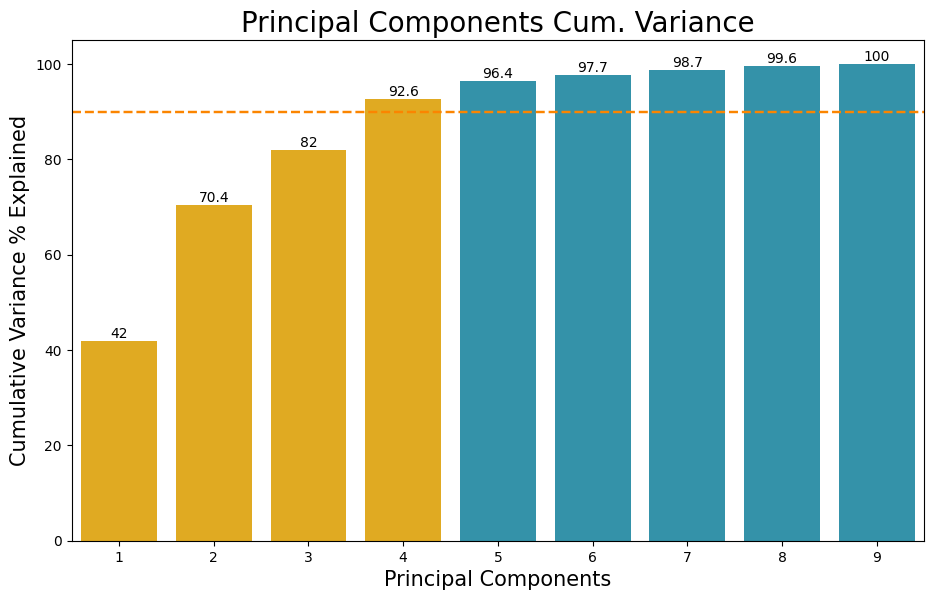

**************************************************************************************************************

Our 4 principal components:


array([[-5.42706645e-01, -8.76951238e-01, -9.53061426e-03,
         5.05860885e-03],
       [-6.94620576e-01,  3.37693692e+00, -9.87110152e-02,
        -8.44614763e-02],
       [-5.42706645e-01, -8.76951238e-01, -9.53061426e-03,
         5.05860883e-03],
       ...,
       [-4.36479467e-02,  2.67104995e+00,  3.24277595e-01,
         6.22613931e-01],
       [-5.51412151e-01, -7.06649958e-01, -1.27360779e-02,
         1.49891256e-03],
       [-5.42706645e-01, -8.76951238e-01, -9.53061426e-03,
         5.05860885e-03]])

In [18]:
# Now that we have our new dataset ready, we search the optimal number of principal components:

def pca_hw4(X, treshold):
    
    # Part 1: We find the optimal number of components ------------------------------------
    n = len(X.axes[1]) # number of columns of X
    covar_matrix = PCA(n_components = n).fit(X) 
  
    ## Variance explained for each of the principal components
    variance = covar_matrix.explained_variance_ratio_
    cumulative_var = np.cumsum( np.round(variance, decimals = 3) * 100 )

    ## Find the number of components you need to go over your treshold:
    num_components = len(cumulative_var) # default value
    for i in range(len(cumulative_var)):
        if cumulative_var[i] >= treshold:
            num_components = i+1
            break     

    # Part 2: Plot to find the number of principal components you need ---------------------

    tot_num_components = len(cumulative_var)
    
    x = [x for x in range(1, tot_num_components + 1)] # numbers from 1 to maximum number of components
    y = [var for var in cumulative_var] # value of the cumulative variance

    # We will color the component that reaches to explain the desired level of variance with a different color
    customized_col = ["#FFB703" if c <= num_components else "#219EBC" for c in x] 

    fig, ax = plt.subplots(figsize=(11, 6.5))

    ax.set_title('Principal Components Cum. Variance', fontsize = 20)
    ax.set_ylabel('Cumulative Variance % Explained', fontsize = 15)
    ax.set_xlabel('Principal Components', fontsize = 15)

    ax.axhline(treshold, color = '#FB8500', linewidth = 1.75, linestyle = "--")

    sns.barplot(x = x,y = y, palette = customized_col) 
    ax.bar_label(ax.containers[0])
    plt.show()

    # Part 3: we perform the PCA with the chosen number of principal components ------------------

    pca = PCA(n_components = num_components)
    principal_components = pca.fit_transform(X)

    # Part 4: Just the print of the dataframe containing the principal components -------------------

    print('*' * 110) # only to divide the output...
    print('')
    print('Our', num_components, 'principal components:')

    return principal_components
    

pca_analysis = pca_hw4(X, treshold = 90)
pca_analysis

As we can see with only 3 principal components we can summarize 82% of the total variance, with 4 components we would have 92.6%                     
We can also try to see the combination of variables that created each principal component with an heatmap.                
_pca.components_**2_ Square the elements of the principal component matrix. This represents the percentage of variance explained by each variable for each principal component.              

The first principal component explains 26% of __average_click_duration__, 25% of __average_duration_per_day__, 4% of __old_movie_duration__, 21% of __new_movie_duration__, 13% of __duration_weekdays__, and 12% of __duration_weekends__.               
The second principal component explains 36% of __days_logged_in__ variable, 33% of __genres_clicked__ and 30% of __longest_consecutive_days__.  

It can be seen that there are no variables in common between the first two principal components.             

The first component refers mainly to variables extracted from the _"duration"_ column of the original dataframe, while the second main component summarizes variables that were constructed from other columns of the original dataframe.     
      
To complete our analysis, we can also see that the third principal component explains 46% of the variance of __old_movie_duration__, 10% of __new_movie_duration__, 20% of __duration_weekdays__, and 24% of __duration_weekends__.

<Axes: >

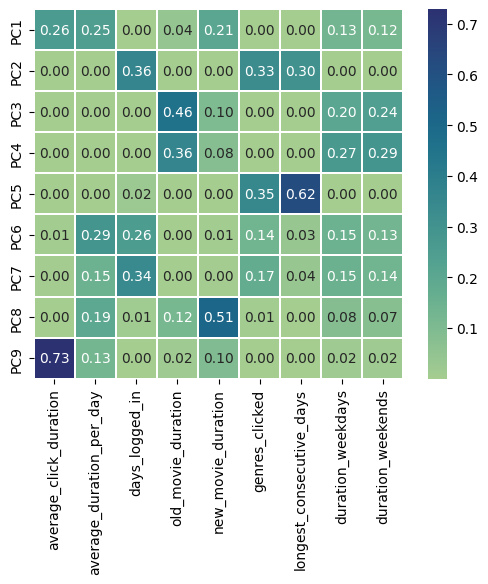

In [63]:
n = len(X.axes[1]) # number of columns of X
pca = PCA(n_components = n).fit(X) 
sns.heatmap(pca.components_**2,
                 yticklabels=["PC"+str(x) for x in range(1, pca.n_components_+1)],
                 xticklabels=to_norm,
                 annot=True,
                 fmt='.2f',
                 square=True,
                 linewidths=0.1,
                 cmap= "crest")

In [ ]:
############ for 2.3 the results of the PCA is in pca_analysis